In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
from deap import benchmarks

from SALib.sample import saltelli,finite_diff, fast_sampler
from SALib.analyze import morris,sobol, dgsm, fast, delta
from SALib.util import read_param_file
from SALib.sample.morris import sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.sample import fast_sampler
from SALib.analyze import fast
from SALib.sample import latin
from SALib.analyze import rbd_fast
from SALib.sample import latin
from SALib.analyze import delta
from tqdm.notebook import tqdm

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

%matplotlib inline

In [11]:

def plotSensitivity(x_samples, sens, conf, title="Sensitivity scores", filename=""):
    #print(sens.shape, conf.shape) #3, 10, 5, 2 = sample_sizes, reps, algs, dim

    avg_sens = np.mean(sens, axis=1)
    avg_conf = np.mean(conf, axis=1)
    std_sens = np.std(sens, axis=1)

    #colors = ['tab:blue','tab:orange','tab:green','tab:purple','tab:brown']
    LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    NUM_STYLES = len(LINE_STYLES)
    colors = sns.color_palette('husl', n_colors=avg_sens.shape[1])
    conf_colors = ['red','red','red','red','red']
    labels = ['Morris','Sobol','Fast', "RDB-Fast", "Delta"]
    cols = labels
    rows = ['X{}'.format(row) for row in range(avg_sens.shape[2])]

    """ #figure per X
    fig, axes = plt.subplots(avg_sens.shape[2], avg_sens.shape[1], sharey=True, figsize=[20,3*avg_sens.shape[2]])
    fig.suptitle(title)
    
    for j in np.arange(avg_sens.shape[2]):
        for i in np.arange(avg_sens.shape[1]):
            axes[j,i].fill_between(x_samples, (avg_sens[:,i,j]-std_sens[:,i,j]), (avg_sens[:,i,j]+std_sens[:,i,j]), color=conf_colors[i], alpha=0.2 )
            axes[j,i].fill_between(x_samples, (avg_sens[:,i,j]-avg_conf[:,i,j]), (avg_sens[:,i,j]+avg_conf[:,i,j]), color=colors[i], alpha=0.1 )
            axes[j,i].plot(x_samples,avg_sens[:,i,j],color=colors[i], label = labels[i])
            axes[j,i].set_xticks(x_samples)
            axes[j,i].set_xscale('log', base=2)
            #if i > 0:
            axes[j,i].set_ylim([0.0,1.0])
    """
    fig, axes = plt.subplots(1, avg_sens.shape[1], sharey=True, figsize=[20,3])
    fig.suptitle(title)
    
    for j in np.arange(avg_sens.shape[2]):
        for i in np.arange(avg_sens.shape[1]):
            axes[i].fill_between(x_samples, (avg_sens[:,i,j]-std_sens[:,i,j]), (avg_sens[:,i,j]+std_sens[:,i,j]), color=colors[j], alpha=0.2 )
            axes[i].fill_between(x_samples, (avg_sens[:,i,j]-avg_conf[:,i,j]), (avg_sens[:,i,j]+avg_conf[:,i,j]), color=colors[j], alpha=0.1 )
            axes[i].plot(x_samples,avg_sens[:,i,j],color=colors[j], linestyle=LINE_STYLES[j%NUM_STYLES] , label = 'X'+str(j))
            axes[i].set_xticks(x_samples)
            axes[i].set_xscale('log', base=2)
            axes[i].set_ylim([0.0,1.0])

    lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    for ax, col in zip(axes, cols):
        ax.set_title(col)

    #for ax, row in zip(axes[:,0], rows):
    #    ax.set_ylabel(row, rotation=0)

    # finally we invoke the legend (that you probably would like to customize...)

    fig.legend(lines, labels)
    #fig.tight_layout()
    #plt.xlabel("sample size")
    #plt.ylabel("sensitivity index")
    plt.savefig(f"{filename}.pdf")
    plt.show()
    plt.clf()
    

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

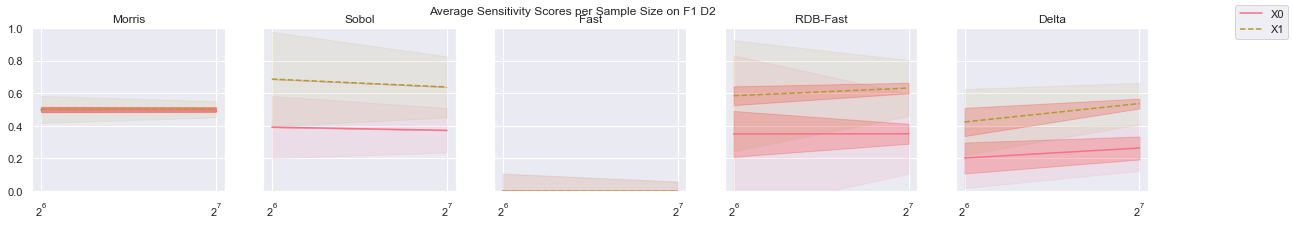

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

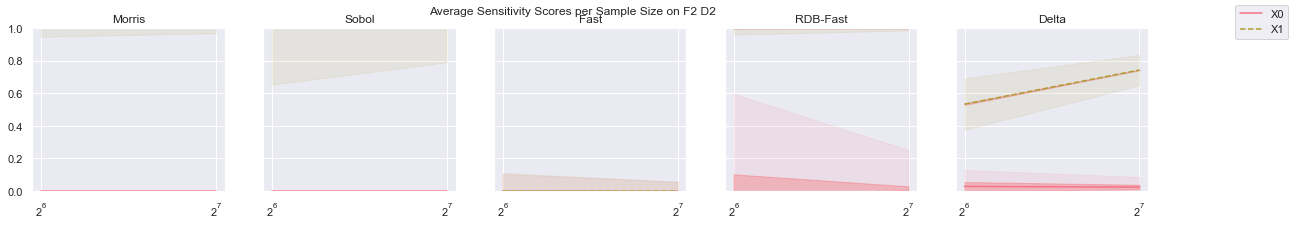

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [12]:
def runSensitivityExperiment(dim, f, title, filename):
    fun, opt = bn.instantiate(f, iinstance=1)
    problem = {
    'num_vars': dim,
    'names': ['X'+str(x) for x in range(dim)],
    'bounds': [[-5.0, 5.0]] * dim
    }
    x_samples = [64,128,256,512,1024,2048,4096,8192] #,8192,16384
    results = []
    conf_results = []
    
    for sample_size in tqdm(x_samples,position=1, leave=False):
        rep_results = []
        rep_conf_results = []
        for rep in tqdm(np.arange(10),position=2, leave=False):
            np.random.seed(rep)
            alg_results = []
            alg_conf_results = []
            X_morris = sample(problem, N=sample_size, num_levels=4, optimal_trajectories=None)
            z_morris =  np.asarray(list(map(fun, X_morris)))

            res_morris = morris.analyze(problem, X_morris, z_morris,
                                        conf_level=0.95,
                                        print_to_console=False,
                                        num_levels=4,
                                        num_resamples=10,
                                        seed=rep)

            mu_star_fixed = np.asarray(res_morris["mu_star"]) / np.sum(res_morris["mu_star"])
            mu_star_conf_fixed = np.asarray(res_morris["mu_star_conf"]) / np.sum(res_morris["mu_star"])

            alg_results.append( mu_star_fixed)
            alg_conf_results.append( mu_star_conf_fixed)

            #Sobol
            X_sobol = saltelli.sample(problem, N=sample_size, calc_second_order=True)
            z_sobol =  np.asarray(list(map(fun, X_sobol)))
            res_sobol = sobol.analyze(problem, z_sobol, print_to_console=False,seed=rep)
            alg_results.append( np.asarray(res_sobol["S1"]))
            alg_conf_results.append( np.asarray(res_sobol["S1_conf"]))
            

            #Fast
            M = 4
            while ((4 * M)**2 > sample_size):
                M -= 1
            
            X_fast = fast_sampler.sample(problem, N=sample_size, M=M, seed=rep)
            z_fast =  np.asarray(list(map(fun, X_fast)))
            res_fast = fast.analyze(problem, z_fast, print_to_console=False,seed=rep)
            alg_results.append( np.asarray(res_fast["S1"]))
            alg_conf_results.append( np.asarray(res_fast["S1_conf"]))

            #rbd #delta
            X_latin = latin.sample(problem, N=sample_size)
            z_latin =  np.asarray(list(map(fun, X_latin)))
            res_rbd = rbd_fast.analyze(problem, X_latin, z_latin, print_to_console=False,seed=rep)
            res_delta = delta.analyze(problem, X_latin, z_latin, print_to_console=False,seed=rep)
            alg_results.append( np.asarray(res_rbd["S1"]))
            alg_conf_results.append( np.asarray(res_rbd["S1_conf"]))
            alg_results.append( np.asarray(res_delta["S1"]))
            alg_conf_results.append( np.asarray(res_delta["S1_conf"]))

            #combine
            rep_results.append(np.asarray(alg_results))
            rep_conf_results.append(np.asarray(alg_conf_results))
        results.append(np.asarray(rep_results))
        conf_results.append(np.asarray(rep_conf_results))

    plotSensitivity(x_samples, np.asarray(results), np.asarray(conf_results), title=title, filename=filename)

from benchmark import bbobbenchmarks as bn

fIDs = bn.nfreeIDs[:]    # for all fcts

for dim in [2,5,10,20]:
    for f in tqdm(fIDs, position=0):
        runSensitivityExperiment(dim, f, title=f"Average Sensitivity Scores per Sample Size on F{f} D{dim}", filename=f"f{f}-d{dim}") #maybe add repetitions